# Download data

In [1]:
import os
import sys
import pandas as pd
sys.path.append("../")
from pyspark.sql import SparkSession
from pyspark.sql.functions import input_file_name, regexp_extract, regexp_replace, to_date
from scripts.download import download_synthetic

In [2]:
download_synthetic() # download data

Successfully downloaded non-transaction files.
Downloaded 2021-02-28
Downloaded 2021-03-01
Downloaded 2021-03-02
Downloaded 2021-03-03
Downloaded 2021-03-04
Downloaded 2021-03-05
Downloaded 2021-03-06
Downloaded 2021-03-07
Downloaded 2021-03-08
Downloaded 2021-03-09
Downloaded 2021-03-10
Downloaded 2021-03-11
Downloaded 2021-03-12
Downloaded 2021-03-13
Downloaded 2021-03-14
Downloaded 2021-03-15
Downloaded 2021-03-16
Downloaded 2021-03-17
Downloaded 2021-03-18
Downloaded 2021-03-19
Downloaded 2021-03-20
Downloaded 2021-03-21
Downloaded 2021-03-22
Downloaded 2021-03-23
Downloaded 2021-03-24
Downloaded 2021-03-25
Downloaded 2021-03-26
Downloaded 2021-03-27
Downloaded 2021-03-28
Downloaded 2021-03-29
Downloaded 2021-03-30
Downloaded 2021-03-31
Downloaded 2021-04-01
Downloaded 2021-04-02
Downloaded 2021-04-03
Downloaded 2021-04-04
Downloaded 2021-04-05
Downloaded 2021-04-06
Downloaded 2021-04-07
Downloaded 2021-04-08
Downloaded 2021-04-09
Downloaded 2021-04-10
Downloaded 2021-04-11
Downloa

In [8]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("YourAppName")  \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "2") \
    .getOrCreate()

data_path = "../data/tables/synthetic/"

# Load data using spark
consumer_details = spark.read.parquet(data_path + "consumer_user_details.parquet")
merchants = spark.read.parquet(data_path + "tbl_merchants.parquet")
consumer_fraud = spark.read.csv(data_path + "consumer_fraud_probability.csv", header=True, inferSchema=True)

# Load pandas data frame
merchants_fraud = pd.read_csv(data_path + "merchant_fraud_probability.csv")
consumer = pd.read_csv(data_path + "tbl_consumer.csv", sep="|")

Next, we want to read the transactions data. Transactions are downloaded individually, and then date of transaction is added manually, since Cloudfront does not allow for the download for entire folders.

In [6]:
transactions = spark.read.parquet(data_path + "transactions/").withColumn("order_datetime", input_file_name())
transactions = transactions.withColumn("order_datetime", regexp_extract(input_file_name(), r'[^/]+$', 0)) # new column for date

# convert new column into date format
transactions = transactions.withColumn("order_datetime", regexp_replace("order_datetime", r'\.parquet$', ''))
transactions = transactions.withColumn("order_datetime", to_date("order_datetime", "yyyy-MM-dd"))

In [7]:
# Print dataset shapes (Rows, Columns)
print(f"Dataset Sizes (Rows, Columns): \n\n \
      \t Transactions Data  : {(transactions.count(), len(transactions.columns))} \n \
      \t Merchant Records   : {(merchants.count(), len(merchants.columns))} \n \
      \t Consumer Data      : {(consumer.count(), len(consumer.columns))} \n \
      \t User Information   : {(consumer_details.count(), len(consumer_details.columns))} \n \
      \t Fraud Probabilities: {(consumer_fraud.count(), len(consumer_fraud.columns))} \n")

Dataset Sizes (Rows, Columns): 

       	 Transactions Data  : (14195505, 5) 
       	 Merchant Records   : (4026, 3) 
       	 Consumer Data      : (name           499999
address        499999
state          499999
postcode       499999
gender         499999
consumer_id    499999
dtype: int64, 6) 
       	 User Information   : (499999, 2) 
       	 Fraud Probabilities: (34864, 3) 



In [107]:
# Show first 3 rows of each dataframe
print("First 3 rows of consumer_details:")
consumer_details.show(3)

print("\nFirst 3 rows of merchants:")
merchants.show(3)

print("\nFirst 3 rows of consumer_fraud:")
consumer_fraud.show(3)

print("\nFirst 3 rows of merchants_fraud:")
print(merchants_fraud.head(3))

print("\nFirst 3 rows of consumer:")
print(consumer.head(3))

First 3 rows of consumer_details:
+-------+-----------+
|user_id|consumer_id|
+-------+-----------+
|      1|    1195503|
|      2|     179208|
|      3|    1194530|
+-------+-----------+
only showing top 3 rows


First 3 rows of merchants:
+--------------------+--------------------+------------+
|                name|                tags|merchant_abn|
+--------------------+--------------------+------------+
|       Felis Limited|((furniture, home...| 10023283211|
|Arcu Ac Orci Corp...|([cable, satellit...| 10142254217|
|    Nunc Sed Company|([jewelry, watch,...| 10165489824|
+--------------------+--------------------+------------+
only showing top 3 rows


First 3 rows of consumer_fraud:
+-------+--------------+-----------------+
|user_id|order_datetime|fraud_probability|
+-------+--------------+-----------------+
|   6228|    2021-12-19| 97.6298077657765|
|  21419|    2021-12-10|99.24738020302328|
|   5606|    2021-10-17|84.05825045251777|
+-------+--------------+-----------------+
o

In [108]:
print("\nFirst 3 rows of transactions:")
print(transactions.head(3))


First 3 rows of transactions:
[Row(user_id=18478, merchant_abn=62191208634, dollar_value=63.255848959735246, order_id='949a63c8-29f7-4ab0-ada4-99ac50a88952', order_datetime=datetime.date(2021, 8, 20)), Row(user_id=2, merchant_abn=15549624934, dollar_value=130.3505283105634, order_id='6a84c3cf-612a-4574-835b-144a47353eff', order_datetime=datetime.date(2021, 8, 20)), Row(user_id=18479, merchant_abn=64403598239, dollar_value=120.15860593212783, order_id='b10dcc33-e53f-4254-863c-de5266810cbc', order_datetime=datetime.date(2021, 8, 20))]


# ***Preprocess transaction***

In [109]:
transactions.describe()

DataFrame[summary: string, user_id: string, merchant_abn: string, dollar_value: string, order_id: string]

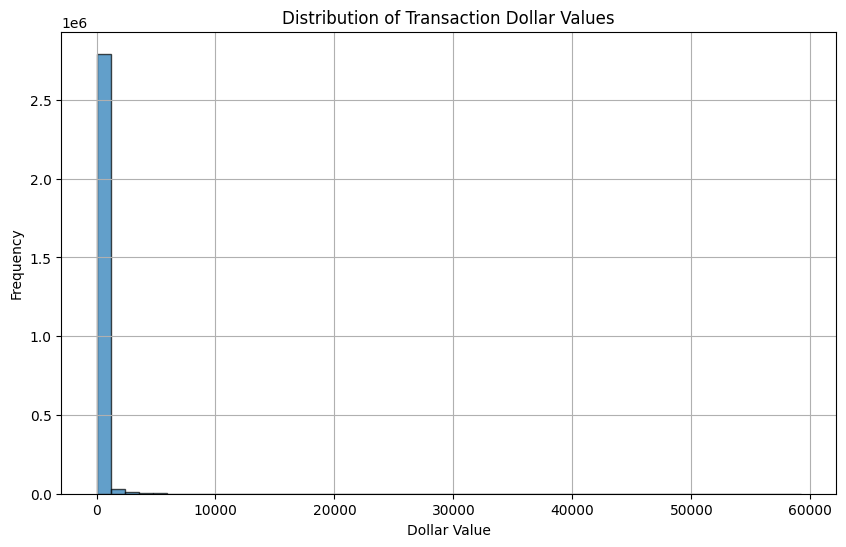

In [110]:
import matplotlib.pyplot as plt

dollar_values = transactions.select("dollar_value").sample(fraction=0.2).toPandas()

# Plotting the distribution of transaction dollar values
plt.figure(figsize=(10,6))
plt.hist(dollar_values['dollar_value'], bins=50, edgecolor='k', alpha=0.7)
plt.title("Distribution of Transaction Dollar Values")
plt.xlabel("Dollar Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### We observe close to 0 transaction, which is very unlikely due to the lack of product in the range and rational consumer shouldn't lend money for such a small purchase. More than 100,000 dollar transaction also appear, which is unlikely and won't be taken into consideration as the BNPL industry ban transactions of more than few thousands due to the risk involve. Both of these are abnormal and can be sign of fraudulent.

#### We thus remove outlier. Outliers are defined as data points that fall outside range:
𝑄
1
−
1.5
×
IQR
and above:
𝑄
3
+
1.5
×
IQR

In [111]:
import numpy as np
from pyspark.sql import functions as F

# Log-transform the dollar_value
transactions = transactions.withColumn('log_dollar_value', F.log(F.col('dollar_value')))

# Calculate Q1 (25th percentile) and Q3 (75th percentile) in a single step using approxQuantile
lwr, upr = transactions.approxQuantile('log_dollar_value', [0.25, 0.75], 0.01)

# Calculate IQR
iqr = upr - lwr

# Determine lower and upper bounds for outliers using the 1.5 * IQR rule
lwr_bound = lwr - 1.5 * iqr
upr_bound = upr + 1.5 * iqr

# Revert the log-transformation to get the actual value of the bounds
lwr_bound, upr_bound = np.exp(lwr_bound), np.exp(upr_bound)

# Print the bounds
print(f"Range of Accepted Transaction Value per order: ${lwr_bound:.2f} - ${upr_bound:.2f}")

# Filter transactions within the bounds
transactions = transactions.filter(
    (F.col('dollar_value') >= lwr_bound) & (F.col('dollar_value') <= upr_bound)
)

# Show filtered transactions
transactions.show()

Range of Accepted Transaction Value per order: $1.80 - $2110.07
+-------+------------+------------------+--------------------+--------------+------------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|  log_dollar_value|
+-------+------------+------------------+--------------------+--------------+------------------+
|  18478| 62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|4.1471875970039065|
|      2| 15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20| 4.870227193386743|
|  18479| 64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20| 4.788812586185273|
|      3| 60956456424| 136.6785200286976|0f09c5a5-784e-447...|    2021-08-20| 4.917631599186548|
|  18479| 94493496784| 72.96316578355305|f6c78c1a-4600-4c5...|    2021-08-20| 4.289954735498426|
|      3| 76819856970|  448.529684285612|5ace6a24-cdf0-4aa...|    2021-08-20|6.1059748650068055|
|  18479| 67609108741|  86.4040605836911|d0e180f0-cb06-42a...| 

### 

### The range now is smaller and seem to be more reasonable. We know that firm like Afterpay has a starting max cap of 500 but if the historical track is good, user can be consider for up to 1500 or 2000 but no more.

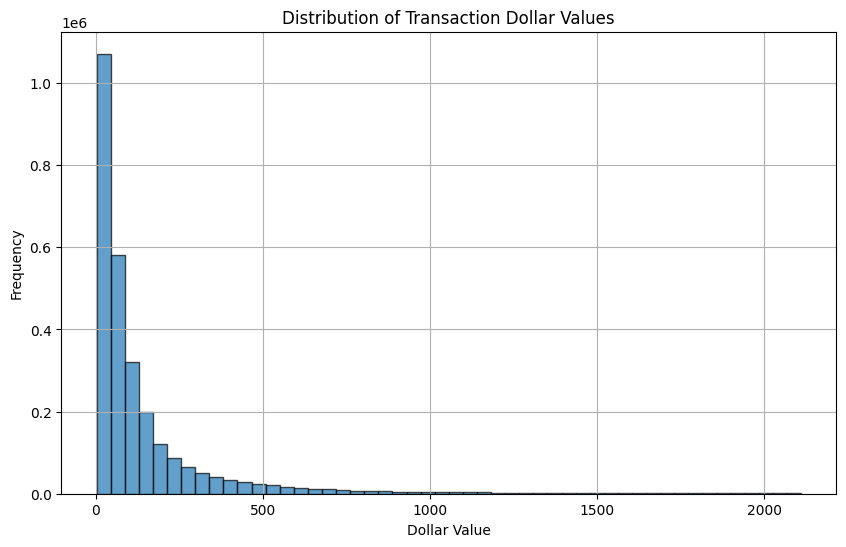

In [112]:
import matplotlib.pyplot as plt

dollar_values = transactions.select("dollar_value").sample(fraction=0.2).toPandas()

# Plotting the distribution of transaction dollar values
plt.figure(figsize=(10,6))
plt.hist(dollar_values['dollar_value'], bins=50, edgecolor='k', alpha=0.7)
plt.title("Distribution of Transaction Dollar Values")
plt.xlabel("Dollar Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [113]:
# Print transactions dataset shapes (Rows, Columns)
print(f"Dataset Sizes (Rows, Columns): \n\n \
      \t Transactions Data  : {(transactions.count(), len(transactions.columns))} \n")

Dataset Sizes (Rows, Columns): 

       	 Transactions Data  : (13895038, 6) 



In [114]:
from pyspark.sql import functions as F

# Create a new DataFrame with the count of nulls per column
null_stats = transactions.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in transactions.columns])

# Show the table with the null statistics
null_stats.show()

+-------+------------+------------+--------+--------------+----------------+
|user_id|merchant_abn|dollar_value|order_id|order_datetime|log_dollar_value|
+-------+------------+------------+--------+--------------+----------------+
|      0|           0|           0|       0|             0|               0|
+-------+------------+------------+--------+--------------+----------------+



# ***Preprocess merchants***

In [115]:
# Create a new DataFrame with the count of nulls per column
null_stats = merchants.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in merchants.columns])

# Show the table with the null statistics
null_stats.show()

+----+----+------------+
|name|tags|merchant_abn|
+----+----+------------+
|   0|   0|           0|
+----+----+------------+



## Remove merchants with no transaction records and transactions with merchant not in our given list

In [116]:
# Get distinct merchant_abn from the transactions dataset
transaction_merchant_abn_set = set(transactions.select('merchant_abn')
                                              .distinct()
                                              .toPandas()['merchant_abn'])

# Filter the merchant dataset to find merchants that do NOT appear in the transactions dataset
merchants_missing_in_transactions = merchants.filter(~merchants['merchant_abn'].isin(list(transaction_merchant_abn_set)))

# Output the result (number of merchants missing in transactions)
print(f"Number of merchants missing in transactions: {merchants_missing_in_transactions.count()}")

Number of merchants missing in transactions: 96


In [117]:
# Create a new DataFrame with only the merchants that appear in the transaction dataset
merchants = merchants.filter(merchants['merchant_abn'].isin(list(transaction_merchant_abn_set)))

In [118]:
# Print merchants dataset shapes (Rows, Columns)
print(f"Dataset Sizes (Rows, Columns): \n\n \
      \t Merchants Data  : {(merchants.count(), len(merchants.columns))} \n")

Dataset Sizes (Rows, Columns): 

       	 Merchants Data  : (3930, 3) 



In [119]:
# Get distinct merchant_abn from the merchants dataset
merchant_abn_set = set(merchants.select('merchant_abn')
                                 .distinct()
                                 .toPandas()['merchant_abn'])

# Filter the transactions dataset to remove rows where merchant_abn is not in the merchants dataset
transactions = transactions.filter(transactions['merchant_abn'].isin(list(merchant_abn_set)))

# Output the result (number of transactions after filtering)
print(f"Number of transactions after filtering: {transactions.count()}")

Number of transactions after filtering: 13335953


## Process the tags column

#### Since there are 3 values store in the 'tags' column, we will split them into 3 separate columns for analysis.

In [120]:
merchants = merchants.withColumn('tags', F.lower(merchants['tags'])) \
                        .withColumn('name', F.lower(merchants['name']))

merchants = merchants.withColumn('tags', F.regexp_replace('tags', r'\[', '('))
merchants = merchants.withColumn('tags', F.regexp_replace('tags', r'\]', ')'))
merchants = merchants.withColumn('type', F.split(merchants['tags'], r'\), \(').getItem(0)) \
                                   .withColumn('rev_level', F.split(merchants['tags'], r'\), \(').getItem(1)) \
                                   .withColumn('take_rate', F.split(merchants['tags'], r'\), \(').getItem(2))

merchants = merchants.drop('tags')

merchants = merchants.withColumn('type', F.regexp_replace('type', r'\(\(', ''))

merchants = merchants.withColumn('take_rate', F.regexp_replace('take_rate', r'\)\)', ''))
merchants = merchants.withColumn('take_rate', F.regexp_replace('take_rate', r'take rate: ', ''))
merchants = merchants.withColumn('take_rate', merchants['take_rate'].cast('float'))
merchants.show(5)

+--------------------+------------+--------------------+---------+---------+
|                name|merchant_abn|                type|rev_level|take_rate|
+--------------------+------------+--------------------+---------+---------+
|       felis limited| 10023283211|furniture, home f...|        e|     0.18|
|arcu ac orci corp...| 10142254217|cable, satellite,...|        b|     4.22|
|ultricies digniss...| 10187291046|watch, clock, and...|        b|     3.29|
| enim condimentum pc| 10192359162|music shops - mus...|        a|     6.33|
|       fusce company| 10206519221|gift, card, novel...|        a|     6.34|
+--------------------+------------+--------------------+---------+---------+
only showing top 5 rows



## Save curated dataset

In [121]:
# Save transactions DataFrame as a Parquet file
transactions.write.mode("overwrite").parquet("../data/curated/curated_transaction")

# Save merchants DataFrame as a Parquet file
merchants.write.mode("overwrite").parquet("../data/curated/curated_merchants")

24/10/01 00:28:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/10/01 00:28:49 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/10/01 00:28:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/10/01 00:28:54 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/10/01 00:28:54 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/10/01 00:28:54 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
